In [ ]:
! pip install pycaret

In [139]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
import plotly.graph_objects as go
from plotly.offline import iplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from pycaret.classification import *
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [135]:
# Calculate scores with Test/Unseen labeled data
def test_score_report(data_unseen, predict_unseen):
    le = LabelEncoder()
    data_unseen["Label"] = le.fit_transform(data_unseen.Churn.values)
    data_unseen["Label"] = data_unseen["Label"].astype(int)
    accuracy = accuracy_score(data_unseen["Label"], predict_unseen["Label"])
    roc_auc = roc_auc_score(data_unseen["Label"], predict_unseen["Label"])
    precision = precision_score(data_unseen["Label"], predict_unseen["Label"])
    recall = recall_score(data_unseen["Label"], predict_unseen["Label"])
    f1 = f1_score(data_unseen["Label"], predict_unseen["Label"])

    df_unseen = pd.DataFrame({
        "Accuracy" : [accuracy],
        "AUC" : [roc_auc],
        "Recall" : [recall],
        "Precision" : [precision],
        "F1 Score" : [f1]
    })
    return df_unseen
# Confusion Matrix
def conf_mat(data_unseen, predict_unseen):
    unique_label = data_unseen["Churn"].unique()
    cmtx = pd.DataFrame(
        confusion_matrix(data_unseen["Churn"], predict_unseen["Churn"], labels=unique_label),
        index=['{:}'.format(x) for x in unique_label],
        columns=['{:}'.format(x) for x in unique_label]
    )
    ax = sns.heatmap(cmtx, annot=True, fmt="d", cmap="YlGnBu")
    ax.set_ylabel('Predicted')
    ax.set_xlabel('Target');
    ax.set_title("Predict Unseen Confusion Matrix", size=14);

In [48]:
df=pd.read_csv('/content/Customer_Churn.csv')

# **1-EDA**

In [5]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [9]:
# Check the current data type of the column
print(df['TotalCharges'].dtype)
# Convert empty strings to NaN
df['TotalCharges'] = df['TotalCharges'].replace(' ', float('nan'))
# Convert the column to float type
df['TotalCharges'] = df['TotalCharges'].astype(float)
print(df['TotalCharges'].dtype)

object
float64


In [10]:
numerical_cols = [col for col in df.columns if df[col].dtype != 'object']
categorical_cols = [col for col in df.columns if df[col].dtype == 'object']
print(numerical_cols)
print(categorical_cols)

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']


## Descriptive Statistics

calculate the summary statistics for numerical colums

In [11]:
numerical_summary = df[numerical_cols].describe()
numerical_summary

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


Calculate frequency distribution for categorical columns

In [12]:
categorical_summary = {}
for col in categorical_cols:
    categorical_summary[col] = df[col].value_counts()
categorical_summary

{'customerID': 7590-VHVEG    1
 3791-LGQCY    1
 6008-NAIXK    1
 5956-YHHRX    1
 5365-LLFYV    1
              ..
 9796-MVYXX    1
 2637-FKFSY    1
 1552-AAGRX    1
 4304-TSPVK    1
 3186-AJIEK    1
 Name: customerID, Length: 7043, dtype: int64,
 'gender': Male      3555
 Female    3488
 Name: gender, dtype: int64,
 'Partner': No     3641
 Yes    3402
 Name: Partner, dtype: int64,
 'Dependents': No     4933
 Yes    2110
 Name: Dependents, dtype: int64,
 'PhoneService': Yes    6361
 No      682
 Name: PhoneService, dtype: int64,
 'MultipleLines': No                  3390
 Yes                 2971
 No phone service     682
 Name: MultipleLines, dtype: int64,
 'InternetService': Fiber optic    3096
 DSL            2421
 No             1526
 Name: InternetService, dtype: int64,
 'OnlineSecurity': No                     3498
 Yes                    2019
 No internet service    1526
 Name: OnlineSecurity, dtype: int64,
 'OnlineBackup': No                     3088
 Yes                    24

### *insights*
##### Customer Demographics:

- There are 7,043 customers in the dataset.
- The gender distribution is almost balanced, with 3,555 males and 3,488 females.
- The majority of customers do not have a partner (3,641) or dependents (4,933).
- the monthly charges which can be a service, subscription or even membership has a min value=18.250000, max value=118.750000 and median value=70.350000 (won't depend on the mean value because it somtetimes get affected by outliers)
- the max number of months that a cusomer has stayed with the company is 72

##### Services:
- Most customers have phone service (6,361), while a relatively small number do not (682).
- Among customers with phone service, roughly equal proportions have multiple lines (3,390) or do not (2,971). Additionally, there is a category of "No phone service" (682).
- Internet service is available to the majority of customers, with fiber optic being the most common type (3,096), followed by DSL (2,421). A significant number of customers (1,526) do not have internet service.

##### Additional Services:

- Among customers with internet service, the availability of additional services like online security, online backup, device protection, tech support, streaming TV, and streaming movies varies. There is a category of "No internet service" (1,526) for each of these services.
- The counts for each category indicate that a significant portion of customers do not have these additional services, actually same 1526 customer.

##### Contract and Billing:

- The majority of customers prefered a month-to-month contract (3,875), followed by two-year (1,695) and one-year (1,473) contracts.
- Paperless billing is preferred by a higher number of customers (4,171) compared to those who opt for traditional paper billing (2,872).

##### Payment Method:

- The most common payment method is electronic check (2,365), followed by mailed check (1,612), bank transfer (1,544), and credit card (1,522).

##### Churn:

Out of the total customers in the dataset, 1,869 customers have churned, while 5,174 customers have not churned.


In [13]:
# relation between being churned and thoso who doesn't have internet service
df.loc[df['OnlineSecurity']=='No internet service','Churn'].value_counts()



No     1413
Yes     113
Name: Churn, dtype: int64

get the churn count of each cat data type, all except customerID

In [14]:
cat_colms_and_churn={}
for col in categorical_cols: # for each col name
    if col!='customerID' and col!='TotalCharges' and col!='Churn':
        cat_colms_and_churn[col]=df.groupby(col)['Churn'].value_counts()


In [15]:
cat_colms_and_churn

{'gender': gender  Churn
 Female  No       2549
         Yes       939
 Male    No       2625
         Yes       930
 Name: Churn, dtype: int64,
 'Partner': Partner  Churn
 No       No       2441
          Yes      1200
 Yes      No       2733
          Yes       669
 Name: Churn, dtype: int64,
 'Dependents': Dependents  Churn
 No          No       3390
             Yes      1543
 Yes         No       1784
             Yes       326
 Name: Churn, dtype: int64,
 'PhoneService': PhoneService  Churn
 No            No        512
               Yes       170
 Yes           No       4662
               Yes      1699
 Name: Churn, dtype: int64,
 'MultipleLines': MultipleLines     Churn
 No                No       2541
                   Yes       849
 No phone service  No        512
                   Yes       170
 Yes               No       2121
                   Yes       850
 Name: Churn, dtype: int64,
 'InternetService': InternetService  Churn
 DSL              No       1962
           

## Data Visualization

**1- numerical data**

In [16]:
numerical_cols

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

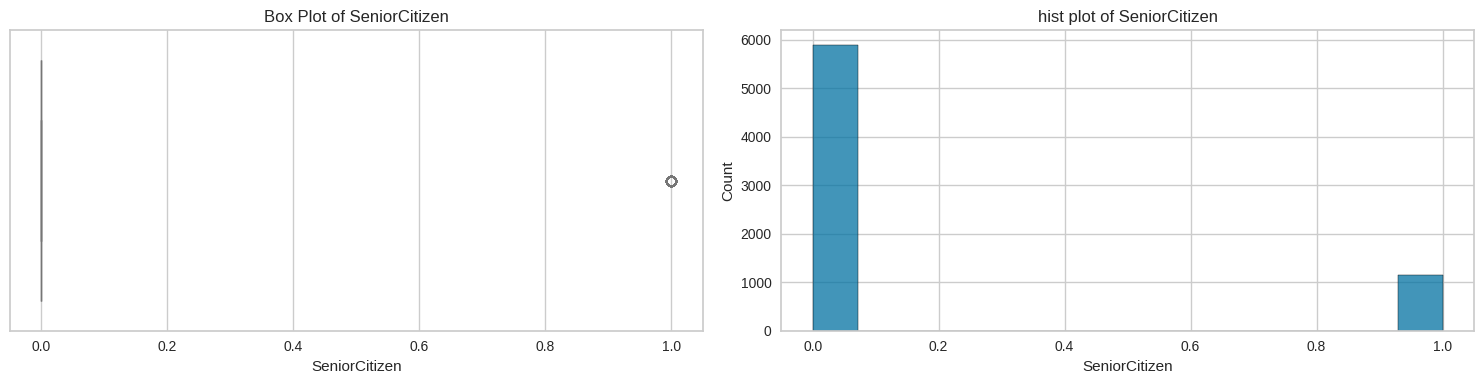

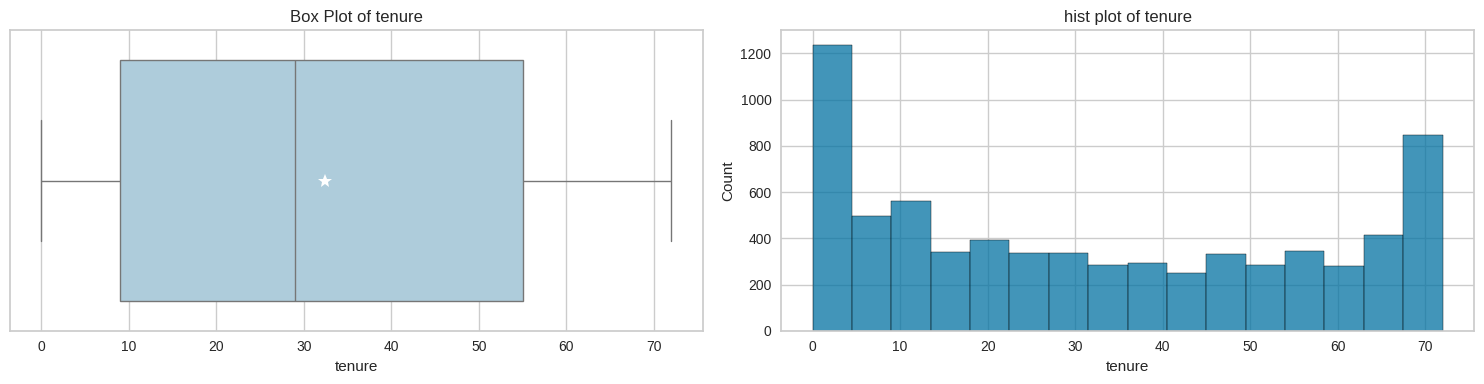

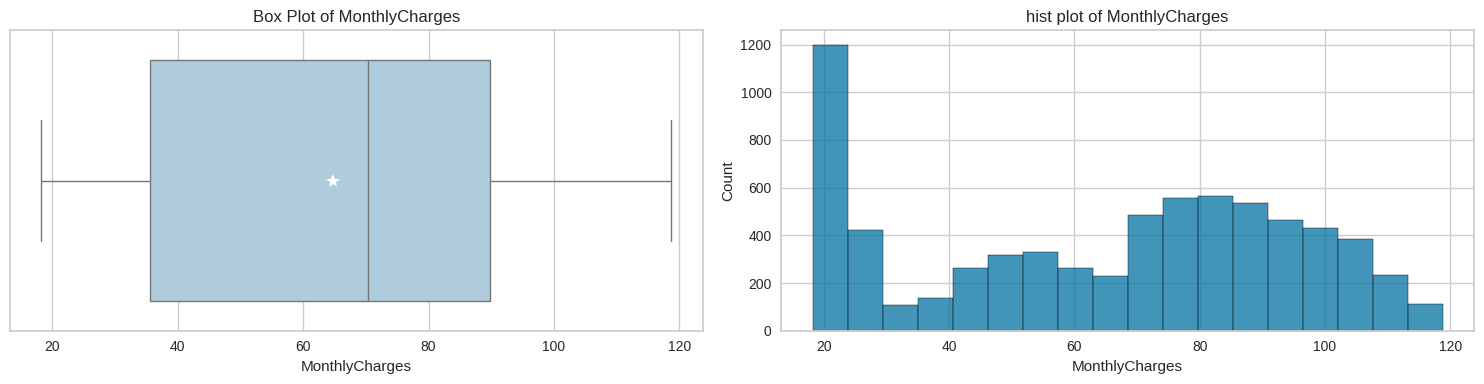

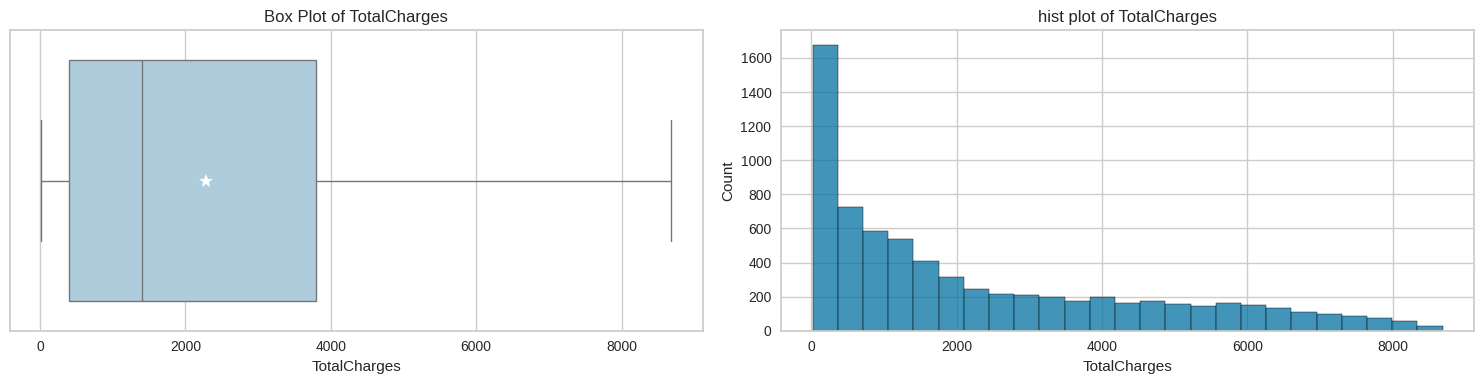

In [17]:
for col in numerical_cols:
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    # Box plot
    sns.boxplot(x=df[col], ax=axes[0],palette="Paired",showmeans=True,meanprops={"marker":"*",
                       "markerfacecolor":"white",
                       "markeredgecolor":"black",
                      "markersize":"10"})
    axes[0].set_title(f'Box Plot of {col}')
    #hist plot
    sns.histplot(data=df,x=df[col],ax=axes[1])
    axes[1].set_title(f'hist plot of {col}')

    # Adjust layout
    plt.tight_layout()
    plt.show()

### correlation analysis

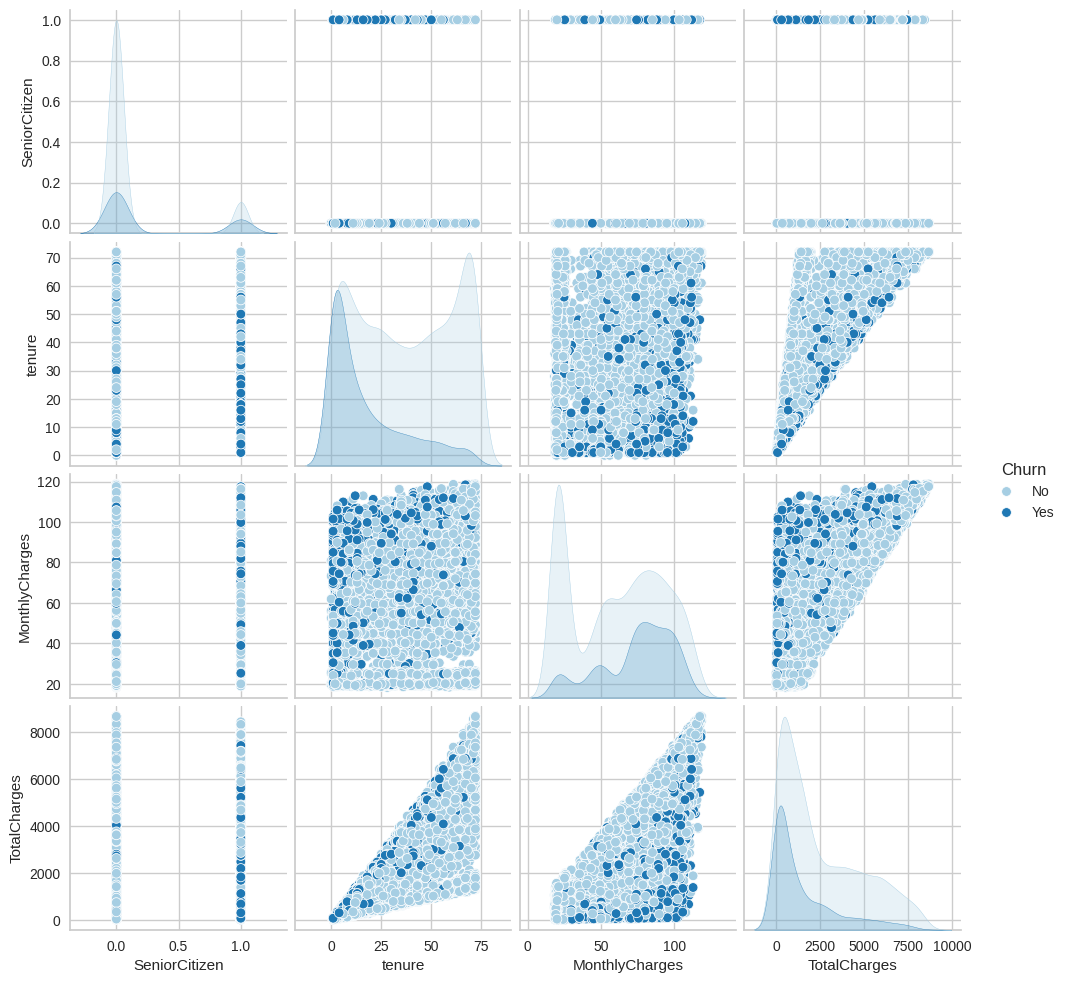

In [18]:
sns.pairplot(data=df, hue="Churn", palette="Paired", diag_kind="kde",kind='scatter')

<Axes: >

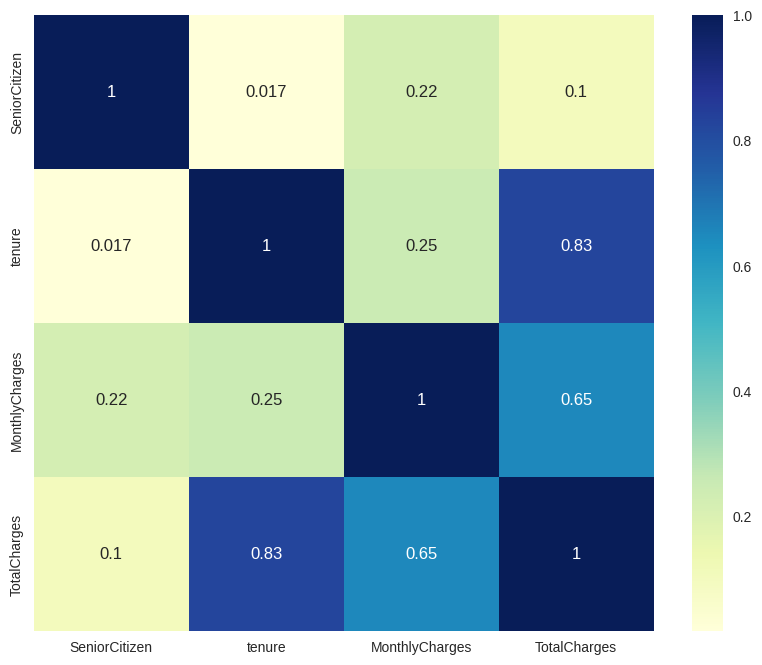

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap="YlGnBu")

## *insights*
- as we can see from the correlation analysis, there's no strong relation between numerical features except for totalcharges with monthlycharges (0.65) , and totalcharges with tenure (0.83)
- the linear relaton between totalcharges and tenure can be due the customer subscription to one or more services ,hence more charges

**2- categorical data**

In [20]:
def pie_plot(data, plot_title: str):
    trace = go.Pie(labels=data.index, values=data.values)
    layout = go.Layout(autosize=False,
                    title={"text" : plot_title,
                       "y" : 0.9,
                       "x" : 0.5,
                       "xanchor" : "center",
                       "yanchor" : "top"})
    fig = go.Figure(data=trace, layout=layout)
    fig.update_traces(textfont_size=14,
                    marker=dict(line=dict(color="#000000", width=2)))
    fig.update_yaxes(automargin=True)
    iplot(fig)
def bar_plot(df, target_col, target_feature, target_feature_classes):
  for target_class in target_feature_classes:
      df_aux = df[df[target_feature] == target_class]
      df_aux = df_aux[target_col].value_counts()

      sns.barplot(x=df_aux.index, y=df_aux.values)

      # Add count values as annotations on top of each bar
      for i, v in enumerate(df_aux.values):
          plt.text(i, v, str(v), ha='center', va='bottom')

      plt.title("Contract Types of " + target_class + " " + target_feature + " Clients")
      plt.xlabel(col)
      plt.ylabel("Count")

      plt.show()
def count_plot(df,col,target_class):
   plt.figure(figsize=(15, 6))
   ax = sns.countplot(x=col, hue=target_class, data=df, palette="rocket")

   # Plot counts on top of bars
   for p in ax.patches:
      ax.annotate(format(p.get_height(), '.0f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'center',
                  xytext = (0, 10),
                  textcoords = 'offset points')

    # Add title and labels
   plt.xlabel(target_class)
   plt.ylabel(col)

   # Show plot
   plt.show()



In [21]:
categorical_cols

['customerID',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

The Client Churn Distribution is checked for any imbalance, as the feature is the target, it's important to choose what strategy to adopt when dealing with imbalanced classes.

Below, a Pie Chart shows the feature distribution.

In [22]:
pie_plot(df['Churn'].value_counts(), plot_title='distrubtion of churn')

**There's some imbalance on Churn Distribution, 26.5% of the clients have churned, and small occurences of a label could lead to bad predictor.**

**It's possible to choose some ways to work with this case:**
1. Make a random over-sampling, duplicating some samples of the minority class until this reach a balance, but this could lead to an overfitted model.

2. Make a random down-sampling, removing some samples from the majority class until this reach a balance, but this leads to information loss and not feeding the model with the collected samples.


3. Another resampling technique, as SMOTE.
4. Choosing a metric that deals with imbalanced datasets, like F1 Score.

The Churn problem is about client retention, so is worth to check about false positives, so precision and recall metrics are a must for this situtation.

F1 Score is used to check the quality of the model predictions, as the metric is an harmonic mean of precision and recall.

**The contract type is a good feature to analyze what happens to a client churn from that service, a plot from the contract types of not churned clients is showed below.**

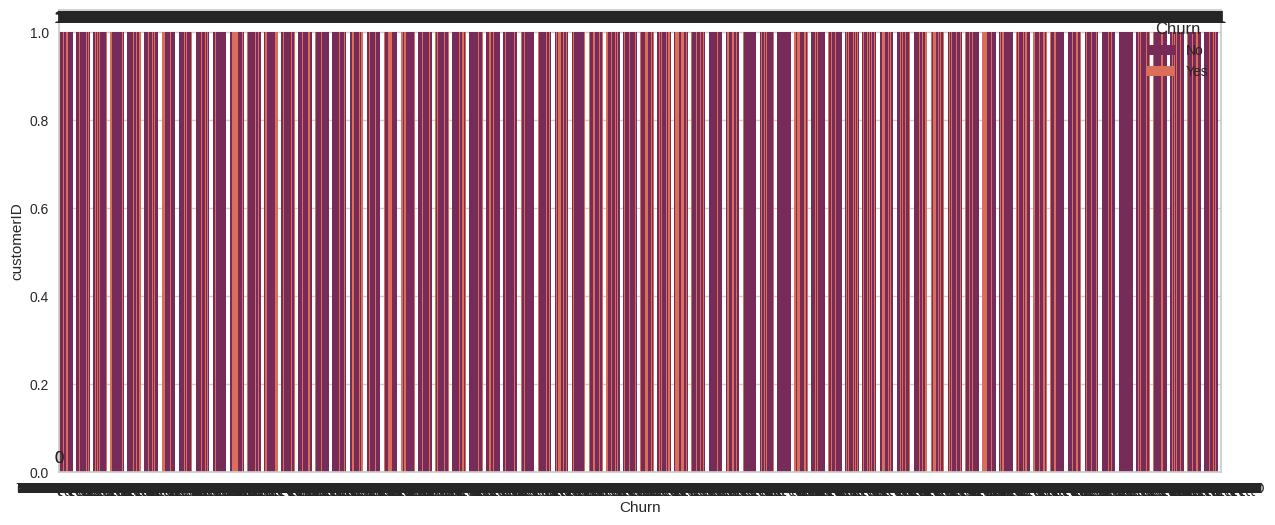

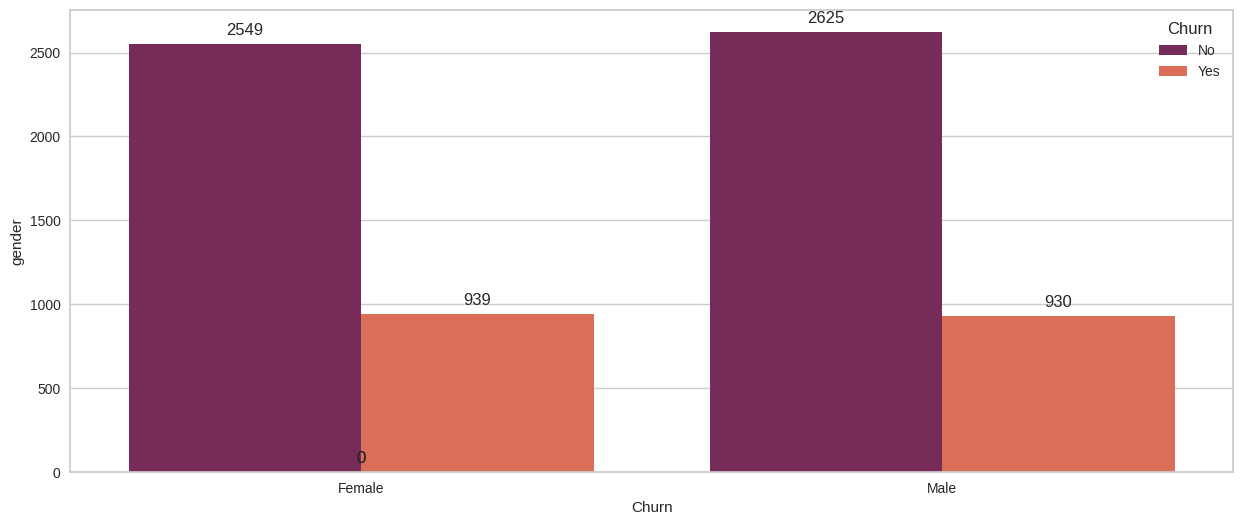

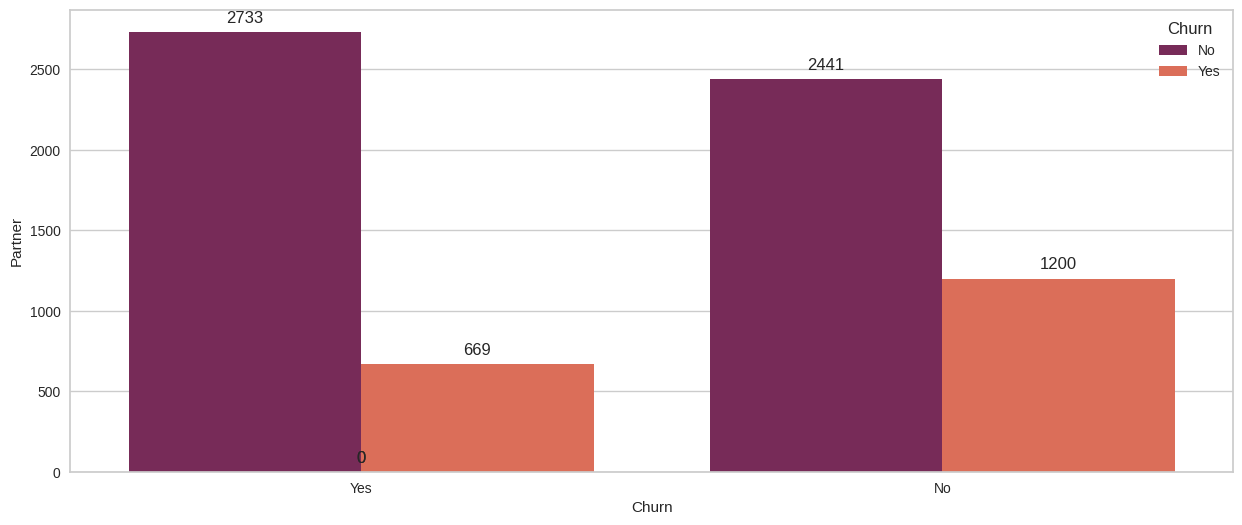

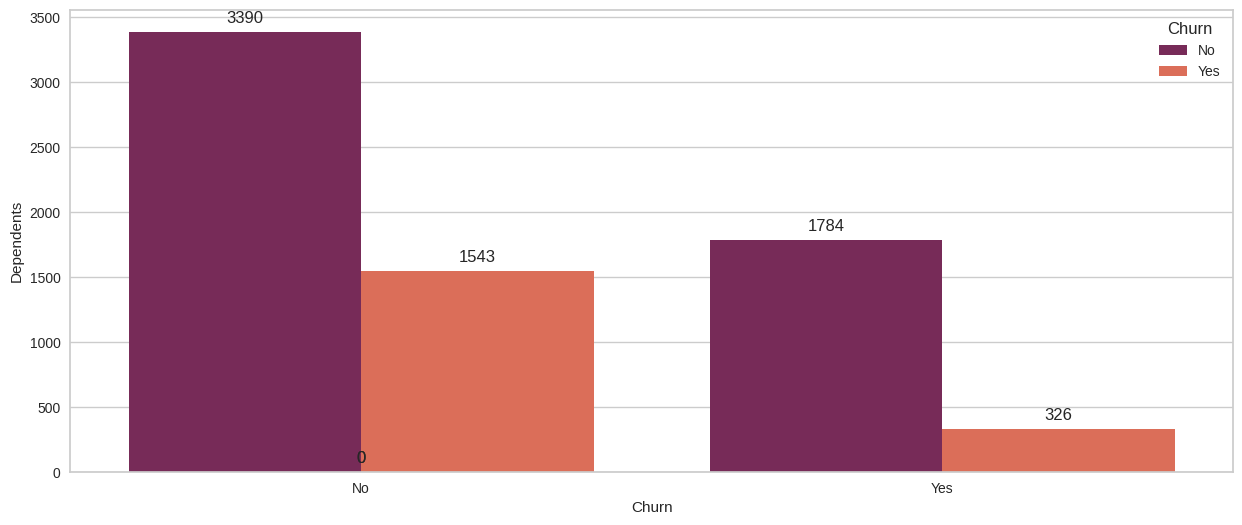

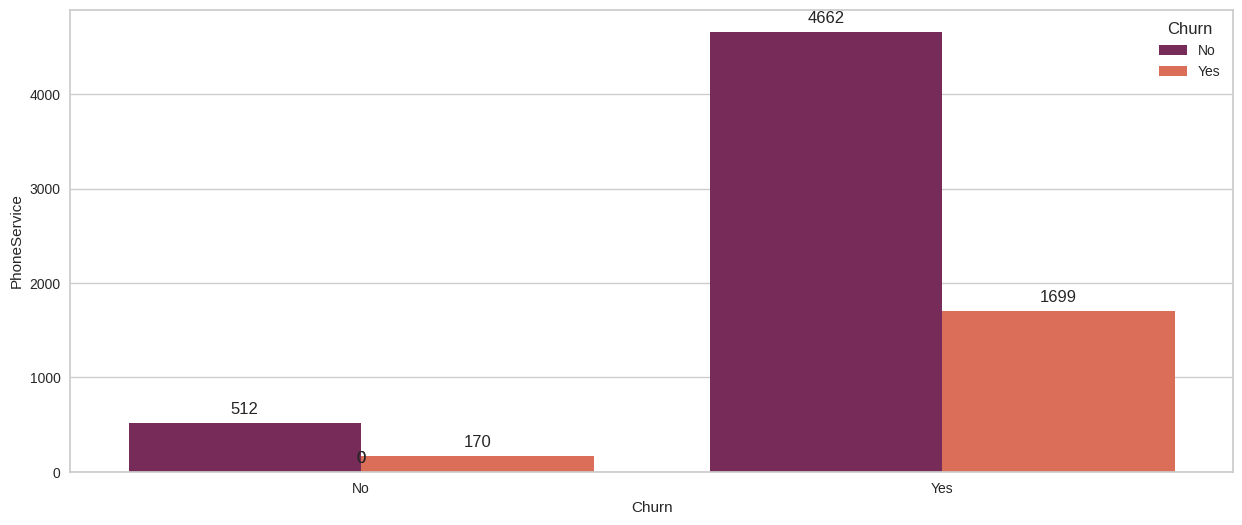

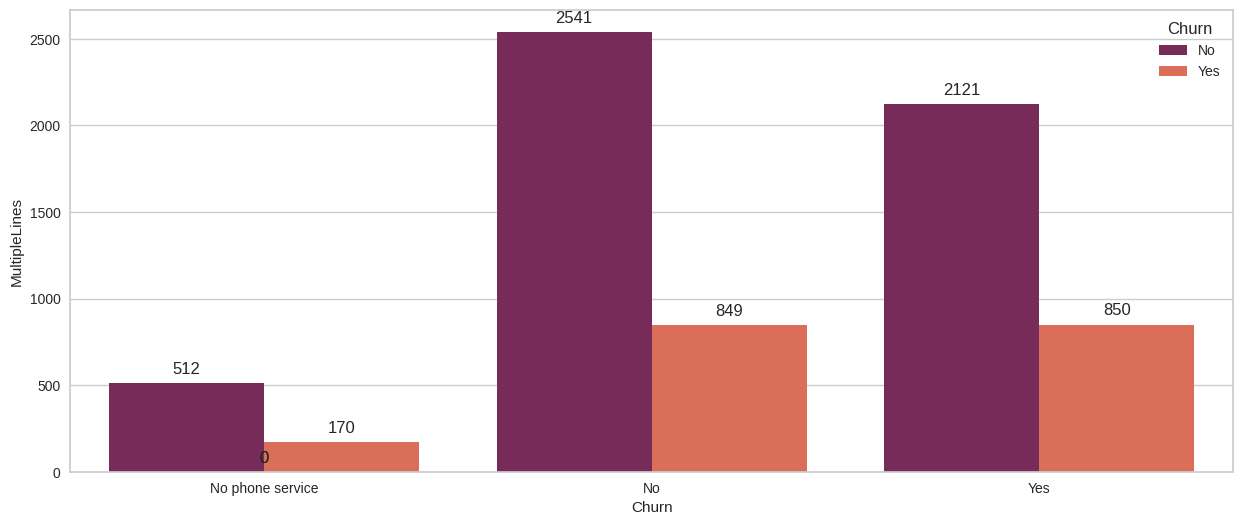

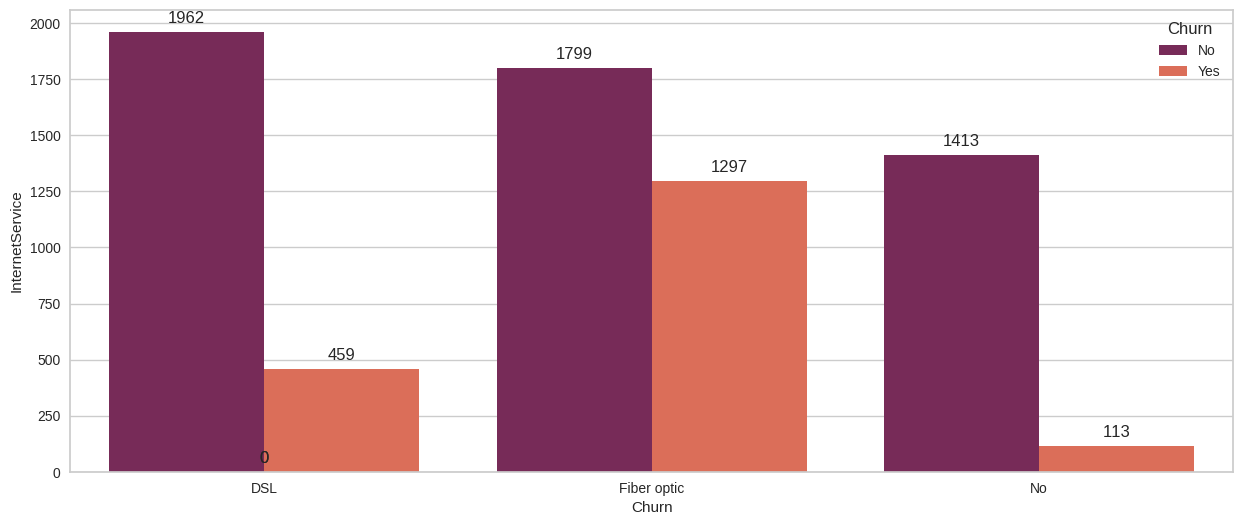

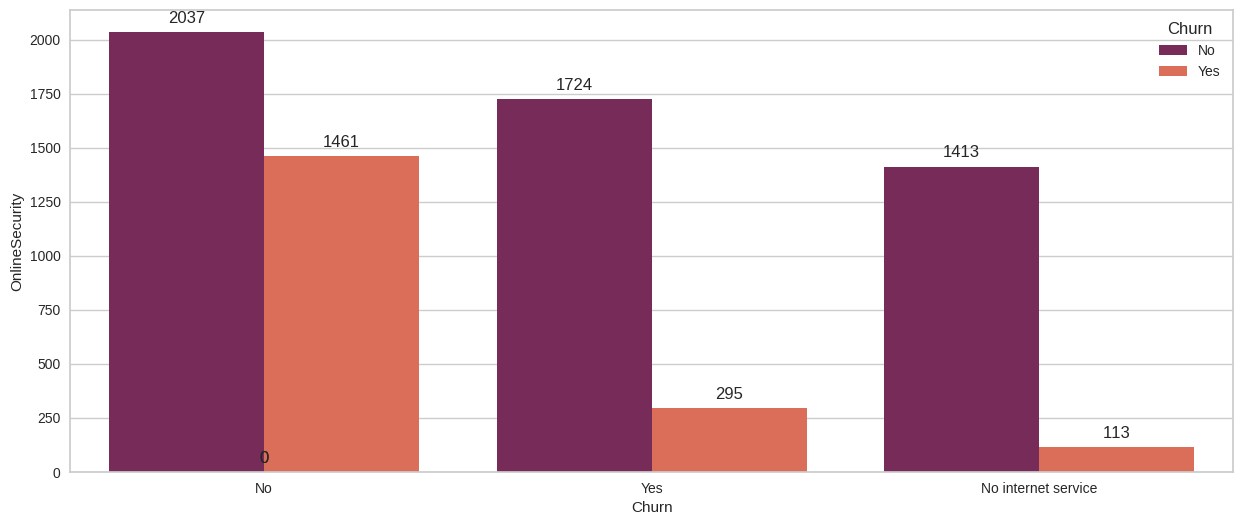

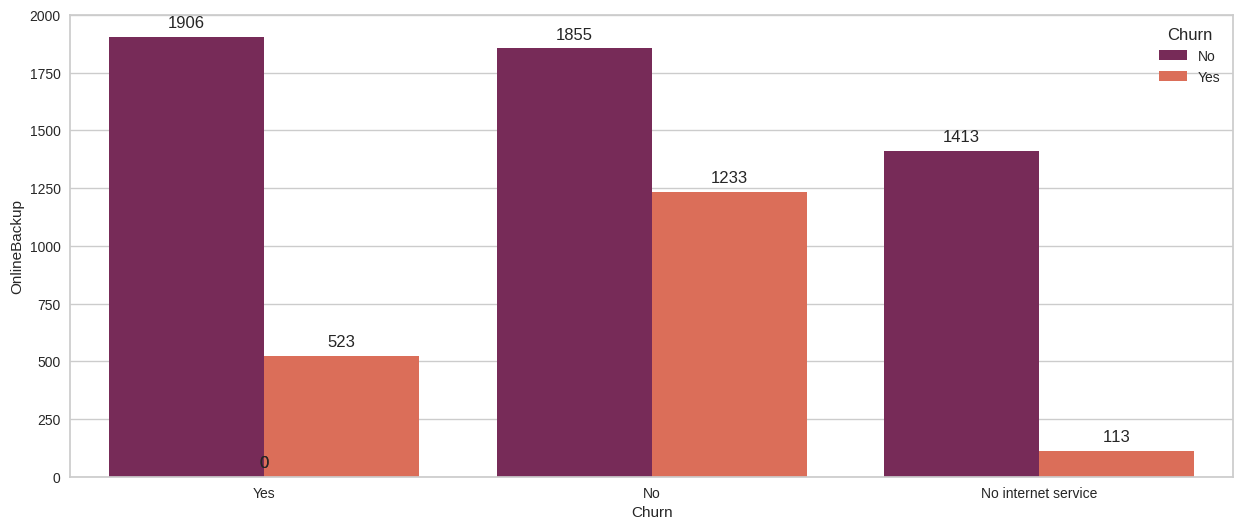

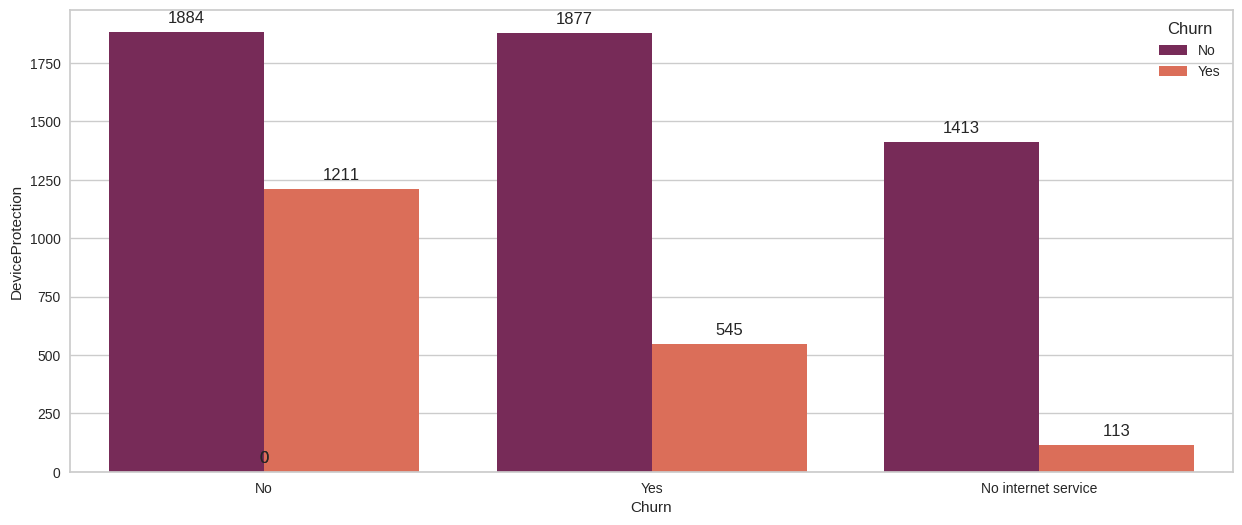

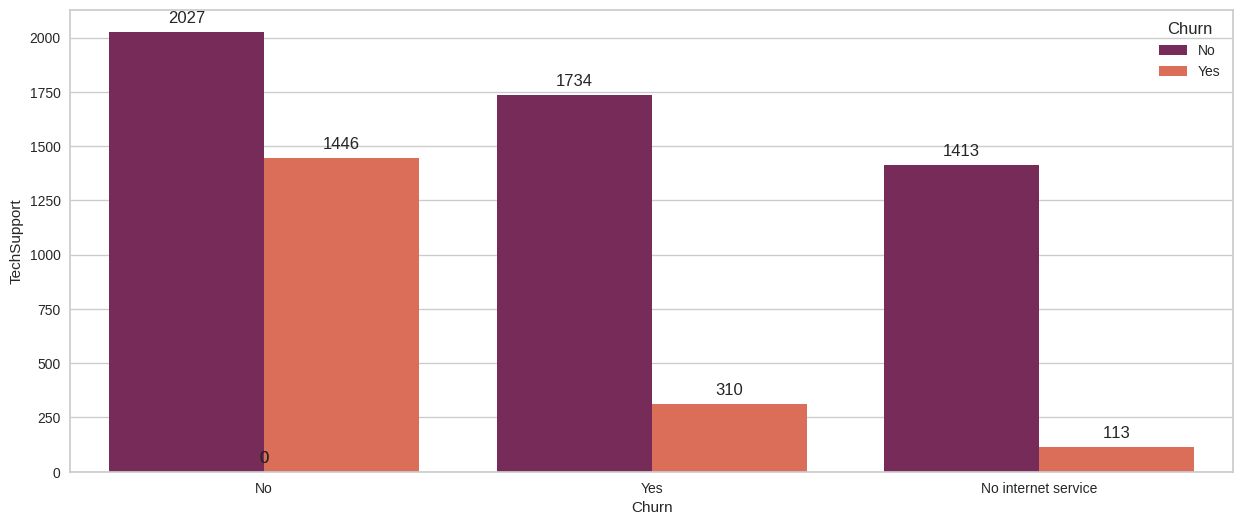

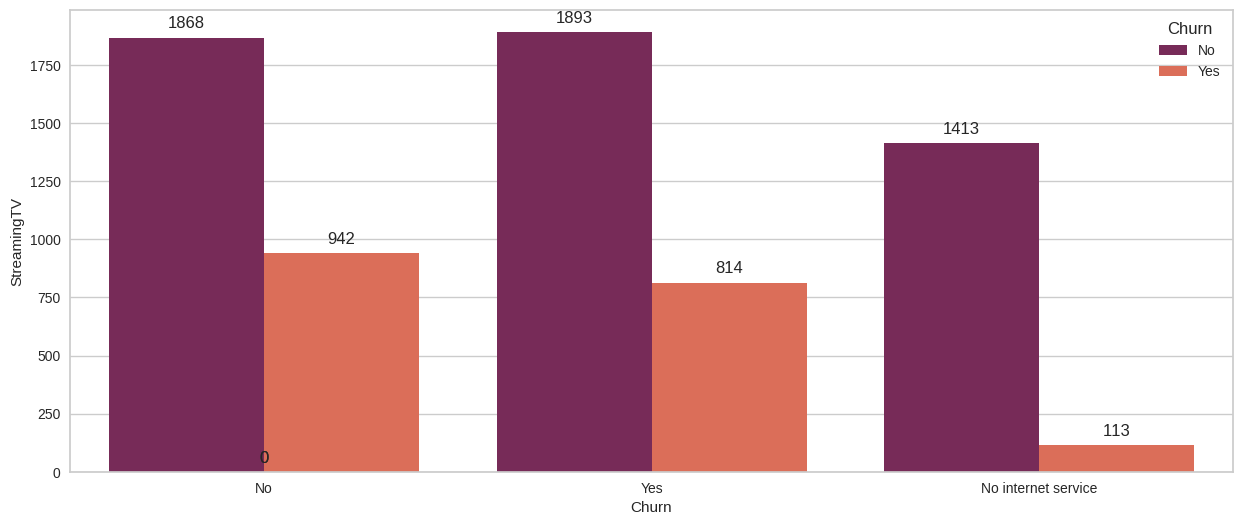

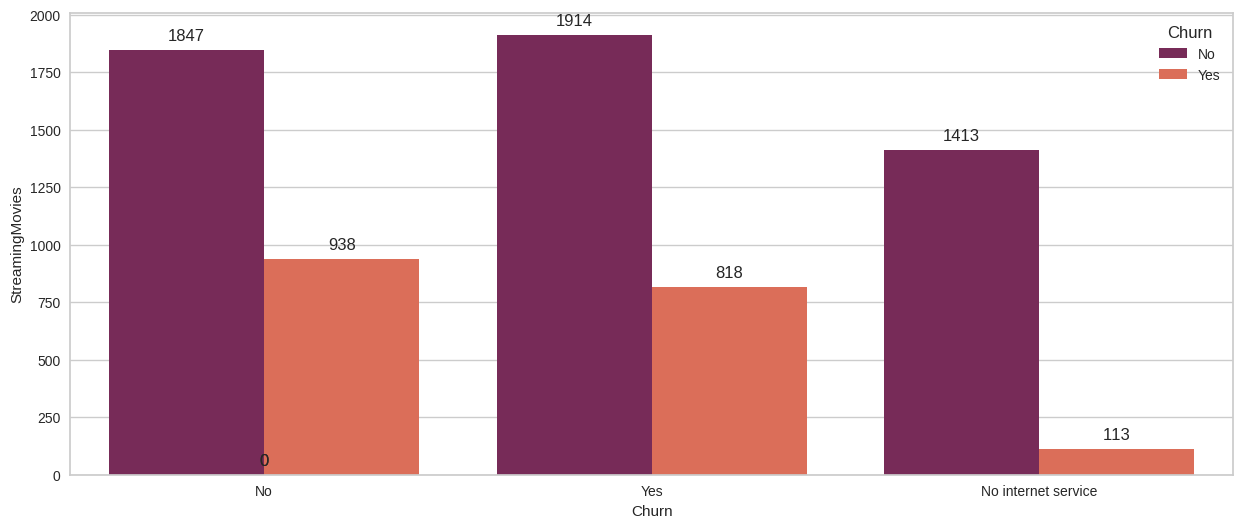

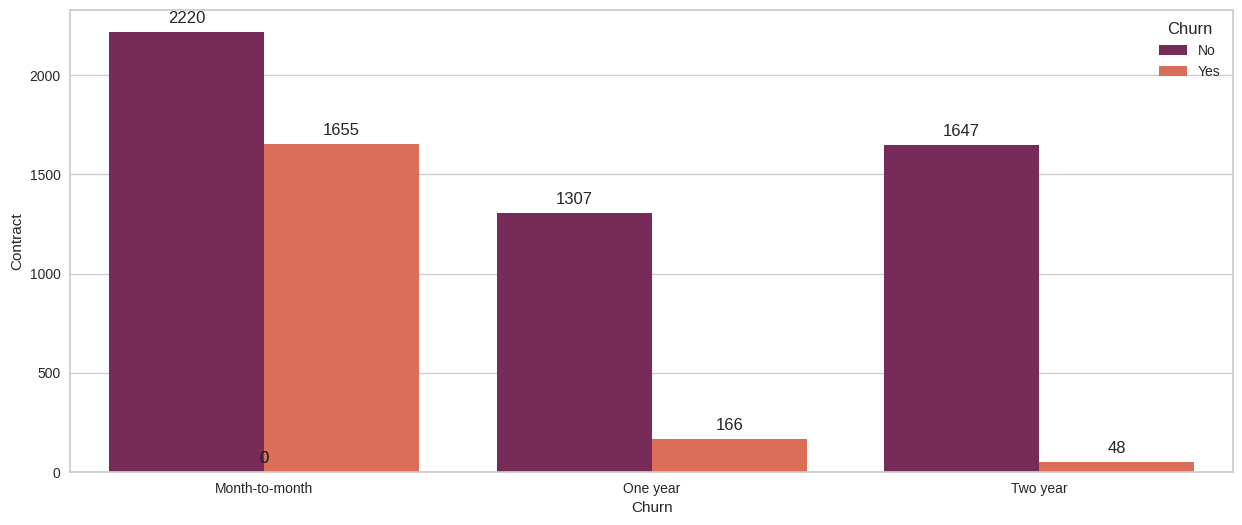

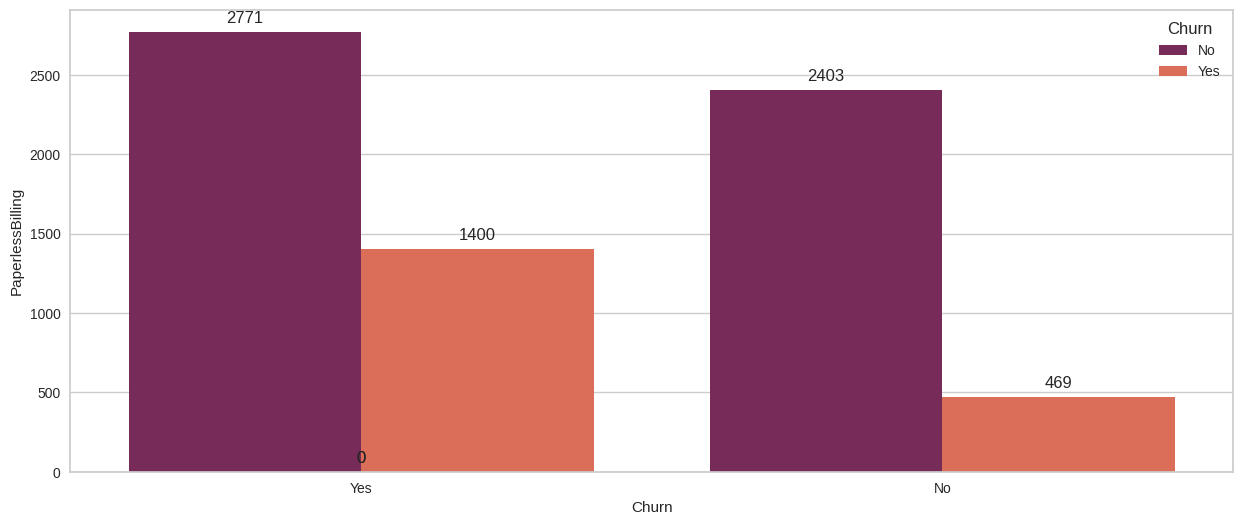

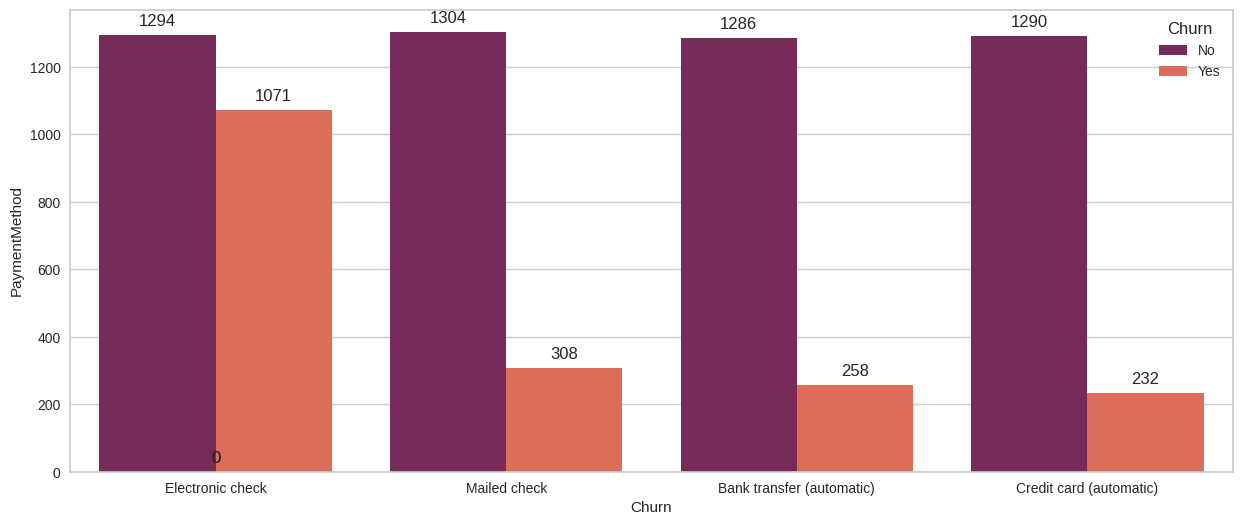

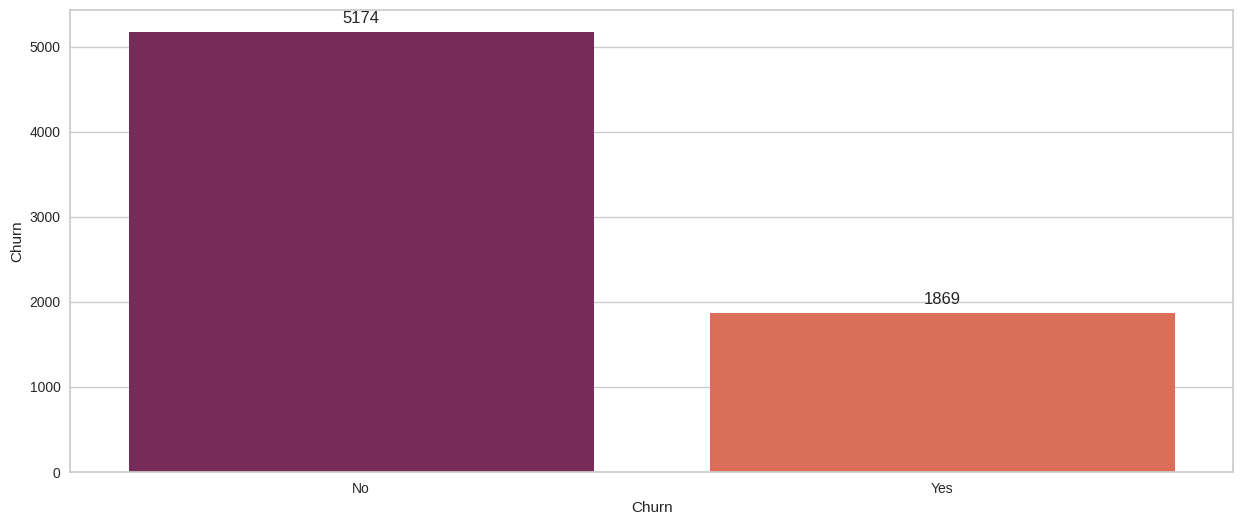

In [23]:
for col in categorical_cols:
    count_plot(df,col,target_class='Churn')


## *insights*
The following features show significant numbers in relation to churn:
- people who doesn't have partners **or** no dependents  are most likely to churn.
- Churn rates vary significantly based on the type of internet service (DSL, fiber optic, or no internet service), Fiber optic class in InternetService has a noticable number of people being churned.
- OnlineSecurity: Churn behavior differs noticeably for customers with and without online security (people with no Online security are most likely to churn)
- OnlineBackup: Churn rates show a notable difference based on whether customers have online backup or not(people with no Online security are most likely to churn)
- DeviceProtection: Churn patterns vary significantly depending on whether customers have device protection or not(people with no DeviceProtection are most likely to churn)
- TechSupport: Churn behavior differs noticeably for customers with and without tech support (people with no TechSupport are most likely to churn)
- Contract: The churn rate significantly differs based on the type of contract (month-to-month, one-year, or two-year), people with month-to-month contract are most likely to churn
- PaperlessBilling: Churn patterns show a noticeable difference for customers with and without paperless billing (people with paperless billing are most likely to churn)
- PaymentMethod: The choice of payment method shows a significant impact on churn rates (people with Electrocnic check payment method are most likely to churn)
- phoneService and multipleLines features aren't very effectice in classification
- 1,869 customers have churned, while 5,174 customers have not churned, so this class is imbalanced
- customerID doesn't seem to be useful feature when it comes to churn predicton

# **2-Feature Engineering**

### Let's apply T-Test and ANOVA Between numerical columns and target coloum
#### Our null hypothesis is there is no correlation or relation between the numerical columns and target one

In [24]:
selectedNumericalFeatuers=[]
significance_level=0.05
numericalColsValuesPValueTTest=[]
numericalColsValuesPValueAnova=[]
numericalColsResult=[]


In [25]:
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [26]:
df.dropna(inplace=True)

In [27]:
for col in numerical_cols:
  print(f"T-tests and ANOVA tests between {col} and Target")
  group1 = df[df['Churn'] == "Yes"][col]
  group2 = df[df['Churn'] == "No"][col]
  t_stat, p_value1 = stats.ttest_ind(group1,group2)
  print("T-test results:")
  print("T-statistic:", t_stat)
  print("P-value:", p_value1)
  numericalColsValuesPValueTTest.append(p_value1)
  if  p_value1 < significance_level:
    print(f"The two coloumns {col} and  Target class are correlated ")

  else:
    print(f"The two coloumns {col} and  Target class are not correlated ")


  # Perform one-way ANOVA
  f_stat, p_value2 = f_oneway(group1, group2)
  print("ANOVA results:")
  print("F-statistic:", f_stat)
  print("P-value:", p_value2)
  numericalColsValuesPValueAnova.append(p_value2)
  if  p_value2 < significance_level:
    print(f"The two coloumns {col} and  Target class are correlated ")
  else:
    print(f"The two coloumns {col} and  Target class are not correlated ")

  if p_value1 < significance_level and p_value2 < significance_level:
    selectedNumericalFeatuers.append(col)
    numericalColsResult.append("Accepted")
  else:
    numericalColsResult.append("Not-Accepted")

  print("-----")

T-tests and ANOVA tests between SeniorCitizen and Target
T-test results:
T-statistic: 12.767631982935935
P-value: 6.3772947115970886e-37
The two coloumns SeniorCitizen and  Target class are correlated 
ANOVA results:
F-statistic: 163.01242645168858
P-value: 6.377294711611359e-37
The two coloumns SeniorCitizen and  Target class are correlated 
-----
T-tests and ANOVA tests between tenure and Target
T-test results:
T-statistic: -31.741289063447653
P-value: 9.437650217574845e-207
The two coloumns tenure and  Target class are correlated 
ANOVA results:
F-statistic: 1007.5094314093412
P-value: 9.437650217603554e-207
The two coloumns tenure and  Target class are correlated 
-----
T-tests and ANOVA tests between MonthlyCharges and Target
T-test results:
T-statistic: 16.47959313114872
P-value: 6.760843117980302e-60
The two coloumns MonthlyCharges and  Target class are correlated 
ANOVA results:
F-statistic: 271.5769897682043
P-value: 6.760843117999019e-60
The two coloumns MonthlyCharges and  T

In [28]:
numericalFeatuersTest= pd.DataFrame({"Feature":numerical_cols,"Pvalue(Anova)":numericalColsValuesPValueAnova,"Pvalue(T-Test)":numericalColsValuesPValueTTest,"Result":numericalColsResult})
numericalFeatuersTest

,Feature,Pvalue(Anova),Pvalue(T-Test),Result
0,SeniorCitizen,6.377295e-37,6.377295e-37,Accepted
1,tenure,9.437650e-207,9.437650e-207,Accepted
2,MonthlyCharges,6.760843e-60,6.760843e-60,Accepted
3,TotalCharges,4.876866e-64,4.876866e-64,Accepted


### Let's apply Chi-Squared Between categorical columns and target coloum
#### Our null hypothesis is there is no correlation or relation between the categorical columns and target one

In [29]:
# Create a contingency table from the DataFrame
selectedCategoricalFeatuers=[]
significance_level = 0.05
categoricalColsValuesPValue=[]
categoricalColsResult=[]
for col in categorical_cols:
  print(f"Test Chi-Squared between {col} and target class ")
  contingency_table = pd.crosstab(df[col], df["Churn"])
  # Run the chi-squared test
  chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
  # Check if the p-value is less than the chosen significance level (e.g., 0.05)
  if col!="Churn":
      categoricalColsValuesPValue.append(p_val)
  if p_val < significance_level and col!="Churn":
      print(f"There are reation between the {col} coloum and target class coloum")
      selectedCategoricalFeatuers.append(col)
      categoricalColsResult.append("Accepted")
  elif col!="Churn":
      print(f"No relation between the {col} coloum and target class coloum ")
      categoricalColsResult.append("Not-Accepted")

  print("P-value:", p_val)
  print("-----")

Test Chi-Squared between customerID and target class 
No relation between the customerID coloum and target class coloum 
P-value: 0.494393294442787
-----
Test Chi-Squared between gender and target class 
No relation between the gender coloum and target class coloum 
P-value: 0.4904884707065509
-----
Test Chi-Squared between Partner and target class 
There are reation between the Partner coloum and target class coloum
P-value: 3.97379757451591e-36
-----
Test Chi-Squared between Dependents and target class 
There are reation between the Dependents coloum and target class coloum
P-value: 2.0196592017051303e-42
-----
Test Chi-Squared between PhoneService and target class 
No relation between the PhoneService coloum and target class coloum 
P-value: 0.34992398942431924
-----
Test Chi-Squared between MultipleLines and target class 
There are reation between the MultipleLines coloum and target class coloum
P-value: 0.0035679273999811405
-----
Test Chi-Squared between InternetService and targe

In [30]:
categoricalColsTest= pd.DataFrame({"Feature":categorical_cols[:-1],"Pvalue(Chi-Squared)":categoricalColsValuesPValue,"Result":categoricalColsResult})
categoricalColsTest

,Feature,Pvalue(Chi-Squared),Result
0,customerID,4.943933e-01,Not-Accepted
1,gender,4.904885e-01,Not-Accepted
2,Partner,3.973798e-36,Accepted
3,Dependents,2.019659e-42,Accepted
4,PhoneService,3.499240e-01,Not-Accepted
5,MultipleLines,3.567927e-03,Accepted
6,InternetService,5.831199e-159,Accepted
7,OnlineSecurity,1.400687e-184,Accepted
8,OnlineBackup,7.776099e-131,Accepted
9,DeviceProtection,1.959389e-121,Accepted


## *insights*
- from the previous data frames we can conclude that:
    - there's statistical corrlatation between numerical columns and the target class (churn), so we're going to use them all for our model
    - for categorical colums, we can see that the null hypothesis is correct for [cusomerID,gender, phoneService] columns, so we won't use those
    columns for the next steps

In [31]:
selectedCategoricalFeatuers

['Partner',
 'Dependents',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [32]:
selectedNumericalFeatuers

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [51]:
selected_dataset=df[selectedCategoricalFeatuers+selectedNumericalFeatuers+["Churn"]]

In [52]:
selected_dataset

,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
0,Yes,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,0,1,29.85,29.85,No
1,No,No,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,0,34,56.95,1889.5,No
2,No,No,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,0,2,53.85,108.15,Yes
3,No,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),0,45,42.30,1840.75,No
4,No,No,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,0,2,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Yes,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,0,24,84.80,1990.5,No
7039,Yes,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),0,72,103.20,7362.9,No
7040,Yes,Yes,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,0,11,29.60,346.45,No
7041,Yes,No,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,1,4,74.40,306.6,Yes


# **3-Data Preprocessing**

### Handling missing values

In [53]:
selected_dataset.isna().sum()

Partner             0
Dependents          0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
SeniorCitizen       0
tenure              0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Handle inconsistent data

In [56]:
#labelEncodingCols = [ elem for elem in selected_dataset.columns if elem!='Churn']
labelEncodingCols=selected_dataset.columns
labelEncodingCols

Index(['Partner', 'Dependents', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'SeniorCitizen', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'Churn'],
      dtype='object')

In [57]:
# Initialize the LabelEncoder
for col in labelEncodingCols:
  label_encoder = LabelEncoder()
  selected_dataset[col] = label_encoder.fit_transform(selected_dataset[col])

**we need to drop the customerID and target class**

In [58]:
#selected_dataset.drop(['Churn'],axis=1,inplace=True)
selected_dataset.head()

,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,0,2,0,0,0,0,0,1,2,0,1,142,2505,0
1,0,0,0,0,2,0,2,0,0,0,1,0,3,0,34,498,1466,0
2,0,0,0,0,2,2,0,0,0,0,0,1,3,0,2,436,157,1
3,0,0,1,0,2,0,2,2,0,0,1,0,0,0,45,266,1400,0
4,0,0,0,1,0,0,0,0,0,0,0,1,2,0,2,729,925,1


In [59]:
df.shape

(7043, 21)

In [60]:
selected_dataset.shape

(7043, 18)

### Data Standarization (mean=0,std=1)

In [61]:
selectedNumericalFeatuers

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [62]:
# Initialize the StandardScaler
scaler = StandardScaler()
# # Standardize the selected numerical columns
selected_dataset[selectedNumericalFeatuers] = scaler.fit_transform(selected_dataset[selectedNumericalFeatuers])

In [63]:
selected_dataset.head(5)

,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
0,1,0,1,0,0,2,0,0,0,0,0,1,2,-0.439916,-1.277445,-1.131766,-0.398608,0
1,0,0,0,0,2,0,2,0,0,0,1,0,3,-0.439916,0.066327,-0.387740,-0.948762,0
2,0,0,0,0,2,2,0,0,0,0,0,1,3,-0.439916,-1.236724,-0.517317,-1.641883,1
3,0,0,1,0,2,0,2,2,0,0,1,0,0,-0.439916,0.514251,-0.872611,-0.983710,0
4,0,0,0,1,0,0,0,0,0,0,0,1,2,-0.439916,-1.236724,0.095041,-1.235224,1


In [64]:
selected_dataset.mean()

Partner             4.830328e-01
Dependents          2.995882e-01
MultipleLines       9.405083e-01
InternetService     8.729235e-01
OnlineSecurity      7.900043e-01
OnlineBackup        9.064319e-01
DeviceProtection    9.044441e-01
TechSupport         7.971035e-01
StreamingTV         9.853756e-01
StreamingMovies     9.924748e-01
Contract            6.904728e-01
PaperlessBilling    5.922192e-01
PaymentMethod       1.574329e+00
SeniorCitizen      -4.842546e-17
tenure             -2.421273e-17
MonthlyCharges     -5.246091e-17
TotalCharges        2.623046e-17
Churn               2.653699e-01
dtype: float64

# **4-Model trainging**

**i'm going to use library called PyCaret which is an open-source, low-code machine learning library in Python that automates machine learning workflows. It is an end-to-end machine learning and model management tool that speeds up the experiment cycle exponentially and makes you more productive.**

*`note that : this library can apply data preprocessing and feature engineering using the setup function, but i already done this, so we'll only use its ability to recommend models and calcaulate the model evaluation metrics`*

Before setting up PyCaret, a random sample of 10% size of the dataset will be get to make predictions with unseen data.

#### init setup

In [81]:
random_seed = 142
def data_sampling(dataset, frac: float, random_seed: int):
    data_sampled_a = dataset.sample(frac=frac, random_state=random_seed)
    data_sampled_b =  dataset.drop(data_sampled_a.index).reset_index(drop=True)
    data_sampled_a.reset_index(drop=True, inplace=True)
    return data_sampled_a, data_sampled_b
data, data_unseen = data_sampling(selected_dataset, 0.9, random_seed)

In [84]:
print(data.shape)
print(data_unseen.shape)

(6339, 18)
(704, 18)


In [102]:
s = setup(data, target ='Churn',session_id = 123)

,Description,Value
0,Session id,123
1,Target,Churn
2,Target type,Binary
3,Original data shape,"(6339, 18)"
4,Transformed data shape,"(6339, 18)"
5,Transformed train set shape,"(4437, 18)"
6,Transformed test set shape,"(1902, 18)"
7,Numeric features,17
8,Preprocess,True
9,Imputation type,simple


**as we can see, the setup funciton applied preprocessing, and the funciton should internally divide data into train and test**

#### model training and selection

```
A great tool on PyCaret is build many models and compare a metric for the bests!

Due the target class imbalance, the models are sorted by F1 Score.
```



In [103]:
best=compare_models(fold=10, sort="F1")


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.7640,0.8235,0.6977,0.5496,0.6139,0.4478,0.4552,0.0400
nb,Naive Bayes,0.7489,0.8207,0.7246,0.5252,0.6080,0.4306,0.4435,0.0370
lda,Linear Discriminant Analysis,0.7929,0.8328,0.5239,0.6412,0.5754,0.4405,0.4452,0.0380
lr,Logistic Regression,0.7945,0.8358,0.5155,0.6477,0.5729,0.4401,0.4458,0.5330
ada,Ada Boost Classifier,0.7917,0.8402,0.5189,0.6400,0.5715,0.4363,0.4414,0.2430
gbc,Gradient Boosting Classifier,0.7951,0.8391,0.4987,0.6557,0.5652,0.4348,0.4425,0.7190
lightgbm,Light Gradient Boosting Machine,0.7800,0.8210,0.4794,0.6167,0.5374,0.3967,0.4031,0.4810
ridge,Ridge Classifier,0.7908,0.0000,0.4517,0.6657,0.5364,0.4079,0.4217,0.0570
xgboost,Extreme Gradient Boosting,0.7706,0.8107,0.4870,0.5888,0.5306,0.3813,0.3856,0.1450
rf,Random Forest Classifier,0.7830,0.8147,0.4559,0.6329,0.5276,0.3924,0.4023,0.5990


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [104]:
print(best)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)


**now PyCaret suggested the Quadratic Discriminant Analysis	Model as it has recall value =0.6977 and F1=0.6139, so let's move on with qda**

# **5-Model Evaluation**

In [105]:
#This function analyzes the performance of a trained model on the test set. It may require re-training the model in certain cases.
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

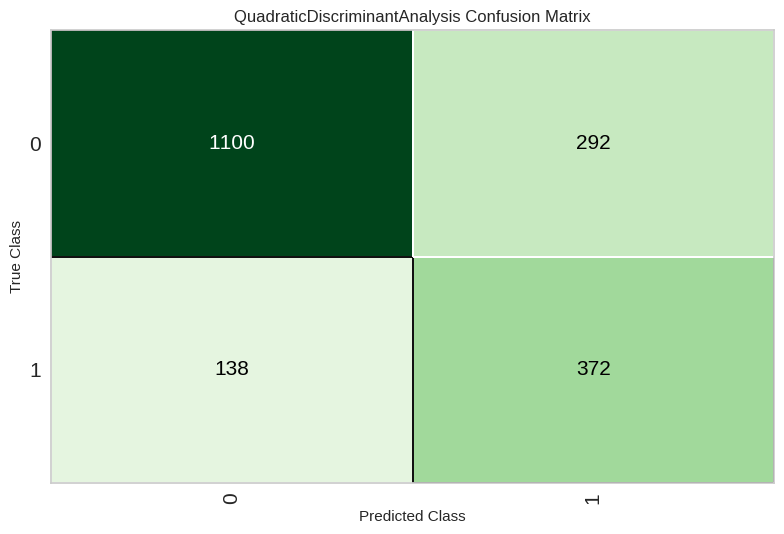

In [106]:
plot_model(best, plot = 'confusion_matrix')

Let's stick with QDA and create the model,also see the hyper-parameters used for build the base model.

In [107]:
base_alg = "qda"
base_model = create_model(base_alg)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7477,0.8262,0.7143,0.5215,0.6028,0.4245,0.4358
1,0.7883,0.8207,0.6807,0.5912,0.6328,0.4851,0.4875
2,0.7770,0.8419,0.6639,0.5725,0.6148,0.4591,0.4616
3,0.7477,0.8210,0.6891,0.5223,0.5942,0.4162,0.4246
4,0.7500,0.8050,0.7143,0.5247,0.6050,0.4283,0.4392
5,0.7860,0.8362,0.7143,0.5822,0.6415,0.4913,0.4965
6,0.7387,0.8015,0.6833,0.5125,0.5857,0.4006,0.4094
7,0.7381,0.8059,0.6891,0.5093,0.5857,0.4005,0.4103
8,0.7878,0.8281,0.6555,0.5954,0.6240,0.4767,0.4777


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [108]:
plot_model(base_model, plot="parameter")

,Parameters
priors,None
reg_param,0.0
store_covariance,False
tol,0.0001


**It's possible to tune the base model and optmize a metric, for this case, F1 Score.**

In [109]:
tuned_model = tune_model(base_model, fold=10, optimize="F1")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7568,0.8227,0.7143,0.5346,0.6115,0.4397,0.4495
1,0.7748,0.8232,0.6891,0.5655,0.6212,0.4632,0.4677
2,0.7748,0.8423,0.7059,0.5638,0.6269,0.4685,0.4745
3,0.7545,0.8263,0.7227,0.5309,0.6121,0.4386,0.4498
4,0.7432,0.8074,0.6975,0.5155,0.5929,0.4115,0.4215
5,0.7770,0.8371,0.7311,0.5649,0.6374,0.4802,0.4885
6,0.7275,0.8001,0.6833,0.4970,0.5754,0.3821,0.3926
7,0.7449,0.8120,0.7059,0.5185,0.5979,0.4174,0.4281
8,0.7946,0.8310,0.6723,0.6061,0.6375,0.4947,0.4960


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


there's no big change in the F1 score after tuning the model, let's see if there's change in the hyperparameters

In [111]:
plot_model(tuned_model, plot="parameter")

,Parameters
priors,None
reg_param,0.17
store_covariance,False
tol,0.0001


The reg_param was higher on the tuned model!! 🙂

let's try to ensemble the model

In [112]:
bagged_model = ensemble_model(tuned_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7568,0.8229,0.6891,0.5359,0.6029,0.4315,0.4386
1,0.7748,0.8218,0.6891,0.5655,0.6212,0.4632,0.4677
2,0.7725,0.8416,0.7059,0.5600,0.6245,0.4645,0.4709
3,0.7635,0.8258,0.7143,0.5449,0.6182,0.4513,0.4600
4,0.7387,0.8062,0.6891,0.5093,0.5857,0.4011,0.4109
5,0.7793,0.8372,0.7227,0.5695,0.6370,0.4816,0.4887
6,0.7252,0.7995,0.6750,0.4939,0.5704,0.3755,0.3854
7,0.7404,0.8120,0.6807,0.5127,0.5848,0.4014,0.4099
8,0.7856,0.8305,0.6555,0.5909,0.6215,0.4725,0.4737


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

after ensembling there's no good change on F1 😞

let's try to blend and stack both models, the tuned and bagged models

In [113]:
blended_model = blend_models(estimator_list=[tuned_model, bagged_model], method="soft")

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7590,0.8230,0.7059,0.5385,0.6109,0.4409,0.4494
1,0.7770,0.8223,0.6891,0.5694,0.6236,0.4672,0.4715
2,0.7703,0.8419,0.7059,0.5563,0.6222,0.4605,0.4672
3,0.7613,0.8261,0.7227,0.5409,0.6187,0.4501,0.4601
4,0.7432,0.8070,0.6975,0.5155,0.5929,0.4115,0.4215
5,0.7748,0.8367,0.7227,0.5621,0.6324,0.4736,0.4814
6,0.7252,0.7999,0.6750,0.4939,0.5704,0.3755,0.3854
7,0.7472,0.8121,0.7059,0.5217,0.6000,0.4212,0.4315
8,0.7901,0.8307,0.6639,0.5985,0.6295,0.4836,0.4848


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

In [114]:
stacked_model = stack_models([tuned_model, bagged_model])

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7770,0.8230,0.5546,0.5893,0.5714,0.4209,0.4213
1,0.7748,0.8224,0.4790,0.6000,0.5327,0.3868,0.3910
2,0.8243,0.8419,0.5546,0.7253,0.6286,0.5162,0.5242
3,0.8041,0.8262,0.5462,0.6633,0.5991,0.4710,0.4749
4,0.7748,0.8070,0.5294,0.5888,0.5575,0.4070,0.4081
5,0.7973,0.8370,0.5714,0.6355,0.6018,0.4663,0.4675
6,0.7680,0.7999,0.5250,0.5780,0.5502,0.3944,0.3952
7,0.7427,0.8121,0.5294,0.5207,0.5250,0.3485,0.3486
8,0.7743,0.8308,0.4202,0.6173,0.5000,0.3610,0.3721


Processing:   0%|          | 0/6 [00:00<?, ?it/s]

# 😶 out of all the experiments .. the tuned_model wins with F1 score of **0.6163**

## let's see the confusion matrix and decide whether to choose it or choose the base_model

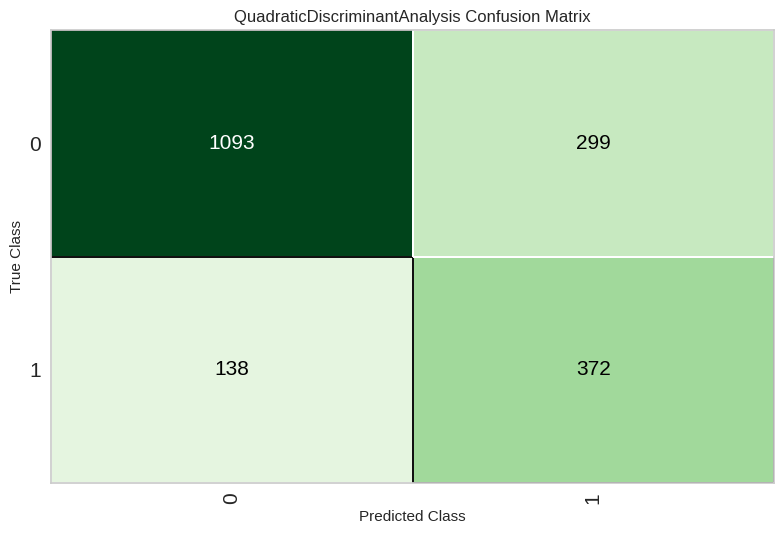

In [115]:
plot_model(tuned_model, plot="confusion_matrix")

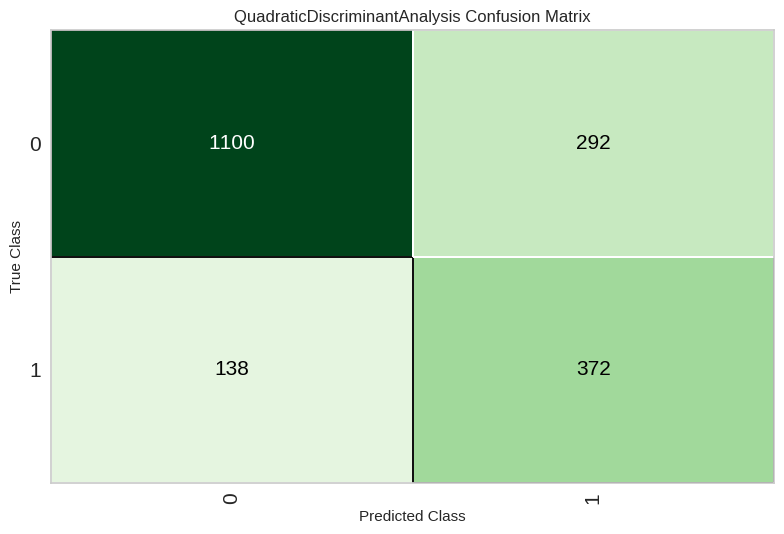

In [117]:
plot_model(base_model, plot="confusion_matrix")

# okay, i found that things are getting worse with the tuned model, so we'll go with the base model (F1=6139)



In [119]:
best_model=base_model

# **5-Model Prediction on test data (30%)**

In [142]:
predict_model(best_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.7739,0.8362,0.7294,0.5602,0.6337,0.4743,0.4829


,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,prediction_label,prediction_score
3028,1,1,2,0,2,0,2,2,2,0,2,1,0,-0.439916,-0.381597,0.341657,-1.046191,0,0,1.0000
5757,1,1,2,1,2,2,2,0,2,2,2,1,0,-0.439916,1.613701,1.654153,1.451480,0,0,0.9999
1582,1,1,1,0,2,0,2,2,2,2,1,1,1,-0.439916,0.432811,-0.276972,-0.512980,0,0,0.9489
5948,0,1,0,0,2,2,0,0,0,0,0,1,2,-0.439916,-0.788800,-0.427449,1.369936,0,0,0.7908
1707,1,1,2,1,0,0,2,0,0,2,2,1,1,-0.439916,1.613701,0.889227,1.036878,0,0,0.9992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432,0,0,0,1,0,0,0,0,0,0,0,0,3,-0.439916,-1.236724,0.095041,-1.445967,0,1,0.6876
1629,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.439916,-1.236724,-0.747213,1.462070,1,1,0.8557
1087,1,1,0,2,1,1,1,1,1,1,0,0,2,-0.439916,0.229209,-1.384652,1.244973,0,0,0.9991
5351,0,0,0,0,0,2,0,0,0,0,0,1,2,-0.439916,-1.277445,-0.611366,0.516905,1,1,0.8301


#🏹  we're getting an F1 score of **0.6337**, recall of **0.7294** and accuracy of **0.7739**

*Score means the probability of the predicted class (NOT the positive class). If prediction_label is 0 and prediction_score is 0.90, this means 90% probability of class 0. If you want to see the probability of both the classes, simply pass raw_score=True in the predict_model function.*

In [122]:
predict_model(best_model,raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.7739,0.8362,0.7294,0.5602,0.6337,0.4743,0.4829


,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,...,PaperlessBilling,PaymentMethod,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,prediction_label,prediction_score_0,prediction_score_1
3028,1,1,2,0,2,0,2,2,2,0,...,1,0,-0.439916,-0.381597,0.341657,-1.046191,0,0,1.0000,0.0000
5757,1,1,2,1,2,2,2,0,2,2,...,1,0,-0.439916,1.613701,1.654153,1.451480,0,0,0.9999,0.0001
1582,1,1,1,0,2,0,2,2,2,2,...,1,1,-0.439916,0.432811,-0.276972,-0.512980,0,0,0.9489,0.0511
5948,0,1,0,0,2,2,0,0,0,0,...,1,2,-0.439916,-0.788800,-0.427449,1.369936,0,0,0.7908,0.2092
1707,1,1,2,1,0,0,2,0,0,2,...,1,1,-0.439916,1.613701,0.889227,1.036878,0,0,0.9992,0.0008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2432,0,0,0,1,0,0,0,0,0,0,...,0,3,-0.439916,-1.236724,0.095041,-1.445967,0,1,0.3124,0.6876
1629,0,0,0,0,0,0,0,0,0,0,...,0,0,-0.439916,-1.236724,-0.747213,1.462070,1,1,0.1443,0.8557
1087,1,1,0,2,1,1,1,1,1,1,...,0,2,-0.439916,0.229209,-1.384652,1.244973,0,0,0.9991,0.0009
5351,0,0,0,0,0,2,0,0,0,0,...,1,2,-0.439916,-1.277445,-0.611366,0.516905,1,1,0.1699,0.8301


*The evaluation metrics are calculated on the test set. The second output is the pd.DataFrame with predictions on the test set (see the last two columns). To generate labels on the unseen (new) dataset, simply pass the dataset in the data parameter under predict_model function.*

# **6-Model Prediction on unseen data (10%)**

In [145]:
predictions = predict_model(best_model, data=data_unseen, raw_score=True)
predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Quadratic Discriminant Analysis,0.7770,0.8532,0.7500,0.5228,0.6161,0.4659,0.4810


,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,...,PaymentMethod,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Label,Churn,prediction_label,prediction_score_0,prediction_score_1
0,0,0,1,0,2,0,0,0,0,0,...,3,-0.439916,-0.910961,-1.135946,-0.343539,0,0,0,0.7324,0.2676
1,0,0,0,2,1,1,1,1,1,1,...,3,-0.439916,0.799294,-1.340762,-1.700658,0,0,0,0.9999,0.0001
2,0,1,2,1,2,0,2,0,2,2,...,0,-0.439916,1.572981,1.516216,1.295276,0,0,0,0.9999,0.0001
3,0,0,1,0,0,0,2,0,0,2,...,2,2.273159,-1.277445,-0.933220,0.043528,1,1,1,0.0114,0.9886
4,1,1,0,0,2,2,0,2,0,0,...,1,-0.439916,0.677133,-0.310411,-0.365778,0,0,0,0.9819,0.0181


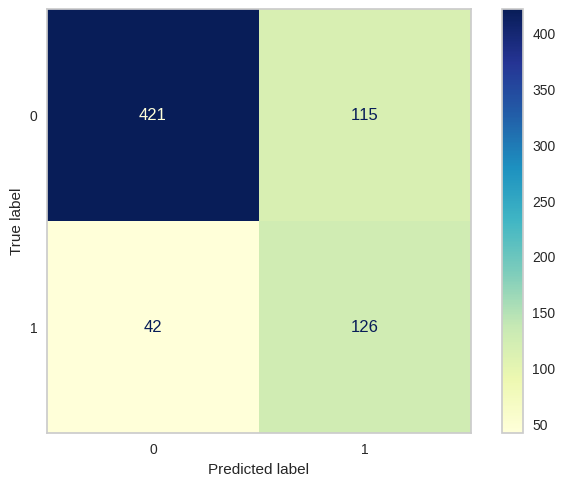

In [164]:
ConfusionMatrixDisplay.from_predictions(data_unseen["Churn"], predictions["prediction_label"], cmap="YlGnBu")
plt.grid(None)

# ↪ let's save the model

In [165]:
save_model(best_model, 'qda_model_0.77_accuracy')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Partner', 'Dependents',
                                              'MultipleLines', 'InternetService',
                                              'OnlineSecurity', 'OnlineBackup',
                                              'DeviceProtection', 'TechSupport',
                                              'StreamingTV', 'StreamingMovies',
                                              'Contract', 'PaperlessBilling',
                                              'PaymentMethod', 'SeniorCitizen',
                                              'tenure', 'MonthlyCharges',
                                              '...
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWrapper(exclude=None, include=[],
      

# **Recommendations**
- The type of contract has a strict relationship with churned clients, Month-to-month contracts with high amount of charges could lead a client to leave the service.
- Churn rates vary significantly based on the type of internet service , Fiber optic class in InternetService has a noticable number of people being churned, so the company should look for any complains or issuses related to this internet service
- OnlineSecurity: Churn behavior differs noticeably for customers with and without online security (people with no Online security are most likely to churn),and the company should enhance this service
- OnlineBackup: Churn rates show a notable difference based on whether customers have online backup or not(people with no Online security are most likely to churn), so the company should should take this in consideration
- DeviceProtection: Churn patterns vary significantly depending on whether customers have device protection or not(people with no DeviceProtection are most likely to churn), data protection and security are the most valuable resources for customers and both should be taken in consideration
- TechSupport: Churn behavior differs noticeably for customers with and without tech support (people with no TechSupport are most likely to churn), tech support is something crucial and it must be improved and applyed for all customers
- PaperlessBilling: Churn patterns show a noticeable difference for customers with and without paperless billing (people with paperless billing are most likely to churn), there might be a problem here also
- PaymentMethod: The choice of payment method shows a significant impact on churn rates (people with Electrocnic check payment method are most likely to churn), so there might be a problem with this kind of payment method